In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import numpy as np
import os
import re

In [2]:
# --- config ---
INPUT_FOLDER_PATH = './csv_data/' 
OUTPUT_FILE = 'feature_engineered_data.csv'

all_weeks_data = []
csv_files = os.listdir(INPUT_FOLDER_PATH)

def get_week_number(filename):
    match = re.search(r'week_(\d+)', filename)
    return int(match.group(1)) if match else 0
csv_files.sort(key=get_week_number)

for filename in csv_files:
    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(INPUT_FOLDER_PATH, filename))
        week_num = get_week_number(filename)
        df['week_num'] = week_num
        all_weeks_data.append(df)

df = pd.concat(all_weeks_data, ignore_index=True)
df.describe()

,rank,peak_rank,previous_rank,weeks_on_chart,streams,week_num
count,31400.000000,31400.000000,31400.000000,31400.000000,3.140000e+04,31400.000000
mean,100.500000,32.233535,88.429172,93.278662,6.106426e+05,79.000000
std,57.735225,39.367805,58.641220,92.617860,4.204912e+05,45.321798
min,1.000000,1.000000,-1.000000,1.000000,2.146070e+05,1.000000
25%,50.750000,4.000000,37.000000,16.000000,3.577338e+05,40.000000
50%,100.500000,14.000000,87.000000,60.000000,4.382090e+05,79.000000
75%,150.250000,53.000000,138.000000,152.000000,7.319112e+05,118.000000
max,200.000000,200.000000,200.000000,423.000000,6.919326e+06,157.000000


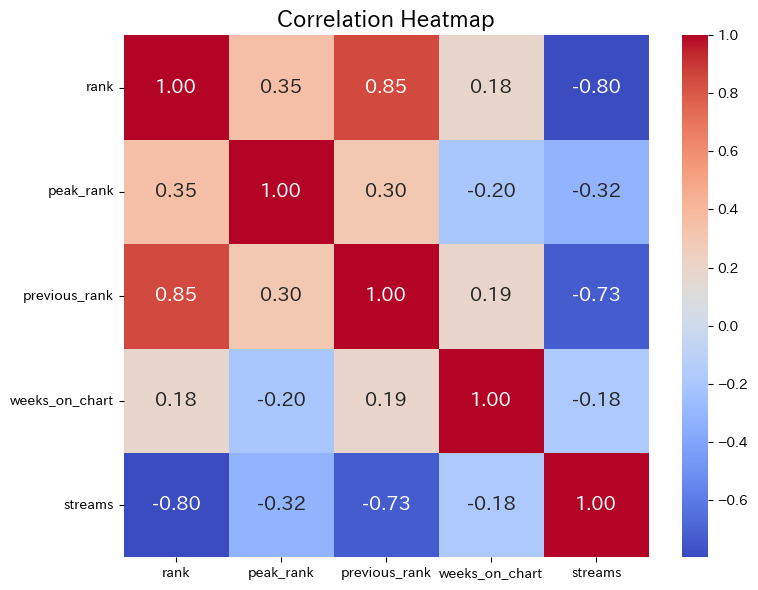

In [12]:
INPUT_FILE = 'feature_engineered_data.csv'

# Load dataset
df_full = pd.read_csv(INPUT_FILE)
    
raw_numerical_columns = ['rank', 'peak_rank', 'previous_rank', 'weeks_on_chart', 'streams']
df0 = df_full[raw_numerical_columns].copy()

# EDA
# correlattion_matrix
correlation_matrix = df0.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f',
    annot_kws={'fontsize': 14}
)
plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()
plt.savefig('raw_eda_correlation_heatmap.png')
    

In [4]:
df.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,week_num
0,1,spotify:track:28MATCYDctW5EiBa2repxb,Ado,新時代,Universal Music LLC,1,1,18,2140379,1
1,2,spotify:track:2Dzzhb1oV5ckgOjWZLraIB,natori,Overdose,なとり,2,2,5,1971187,1
2,3,spotify:track:4NaaF28BeO9WzjDrSS71Nz,Mrs. GREEN APPLE,ダンスホール,Universal Music LLC,2,3,20,1684338,1
3,4,spotify:track:4IfrM44LofE9bSs6TDZS49,Tani Yuuki,W / X / Y,Valley Records,1,4,42,1659011,1
4,5,spotify:track:5YQNjKZofFhlBCIzTVY6rW,Ado,私は最強,Universal Music LLC,2,5,16,1573903,1


In [5]:
# uniqueID for songs
df['song_id'] = df['artist_names'] + ' - ' + df['track_name']

# sorting for time series data
df.sort_values(by=['song_id', 'week_num'], inplace=True)

# target variable
# 'rank_after_4w'
df['rank_after_4w'] = df.groupby('song_id')['rank'].shift(-4)

# # feature engineering
# lag rank
df['rank_t-2'] = df.groupby('song_id')['rank'].shift(2)
df['rank_t-4'] = df.groupby('song_id')['rank'].shift(4) 

# moving average
df['rank_ma_4w'] = df.groupby('song_id')['rank'].transform(lambda x: x.rolling(window=4).mean().shift(1))
df['rank_ma_8w'] = df.groupby('song_id')['rank'].transform(lambda x: x.rolling(window=8).mean().shift(1))

# momentam
df['rank_change_1w'] = df.groupby('song_id')['rank'].diff(1) 

# Delete rows where the 4-week ranking and moving average could not be calculated
df.dropna(inplace=True)

# convert to int
df['rank_after_4w'] = df['rank_after_4w'].astype(int)

# save
df.to_csv(OUTPUT_FILE, index=False)

print(f"最終的なデータ件数: {len(df)}行")

preview_cols = [
    'song_id', 'week_num', 'rank', 
    'rank_ma_4w', 'rank_change_1w', 'weeks_on_chart', 
    'rank_after_4w'
]
print(df[preview_cols].head())

最終的なデータ件数: 21987行
             song_id  week_num  rank  rank_ma_4w  rank_change_1w  \
3205  10-FEET - 第ゼロ感        17     6        7.50             0.0   
3404  10-FEET - 第ゼロ感        18     5        6.75            -1.0   
3604  10-FEET - 第ゼロ感        19     5        5.75             0.0   
3805  10-FEET - 第ゼロ感        20     6        5.50             1.0   
4006  10-FEET - 第ゼロ感        21     7        5.50             1.0   

      weeks_on_chart  rank_after_4w  
3205               9              7  
3404              10              8  
3604              11              8  
3805              12             10  
4006              13             11  


In [6]:
INPUT_FILE = 'feature_engineered_data.csv'

df = pd.read_csv(INPUT_FILE)

X = df.drop(columns=[
    'song_id', 'artist_names', 'track_name', 'uri', 'source', 
    'week_num', 
    'rank',
    'rank_after_4w' # target
])
y = df['rank_after_4w']
# ----------------------------------------------------

# split(8:2)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
import lightgbm as lgb

# LightGBM setting
model = lgb.LGBMRegressor(
    objective='regression_l1', 
    metric='rmse',            
    n_estimators=1000,         
    learning_rate=0.05,        
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=True)]
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1870
[LightGBM] [Info] Number of data points in the train set: 17589, number of used features: 9
[LightGBM] [Info] Start training from score 103.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	valid_0's rmse: 23.7106


LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=1000,
              objective='regression_l1', random_state=42)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 1. prediction
y_pred = model.predict(X_test)

# 2. r2・RMSE・MAE
r2 = r2_score(y_test, y_pred)
print(f"決定係数 (R^2): {r2:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")



決定係数 (R^2): 0.8109
RMSE: 23.7106
MAE: 16.2818


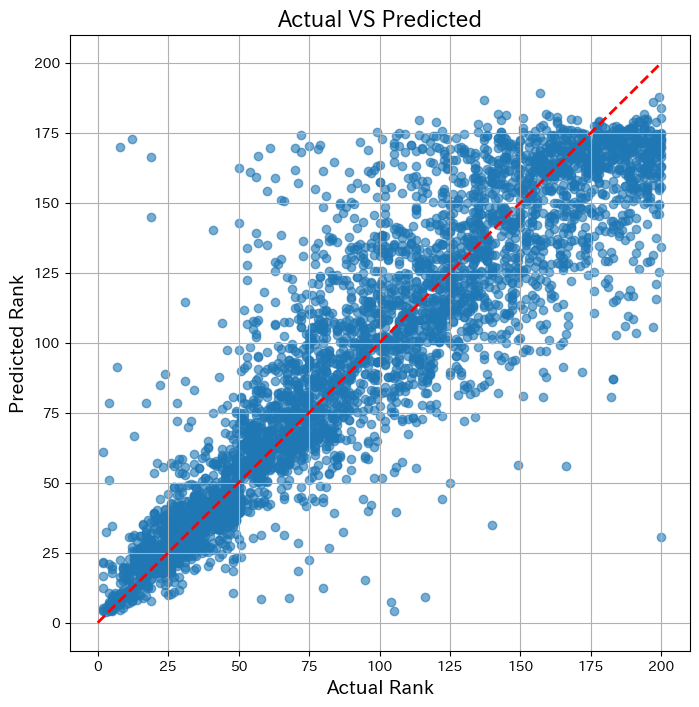

In [14]:
# Actual VS Predicted plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Rank", fontsize=14)
plt.ylabel("Predicted Rank", fontsize=14)
plt.title("Actual VS Predicted", fontsize=16)

plt.plot([0, 200], [0, 200], color='red', linestyle='--', linewidth=2)
plt.grid(True)
plt.savefig('actual_predicted.png') 
plt.show()

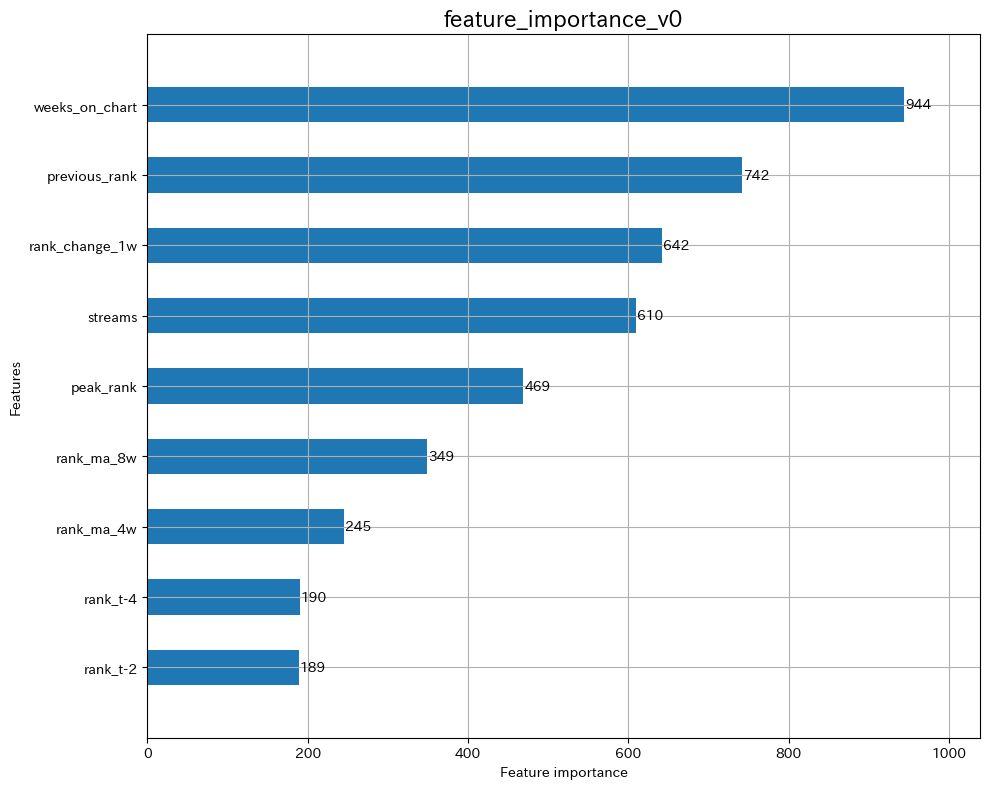

In [10]:
# feature importance
lgb.plot_importance(model, height=0.5, figsize=(10, 8), max_num_features=15)
plt.title('feature_importance_v0', fontsize=16)
plt.tight_layout()
plt.savefig('feature_importance_tuned_v0.png') 

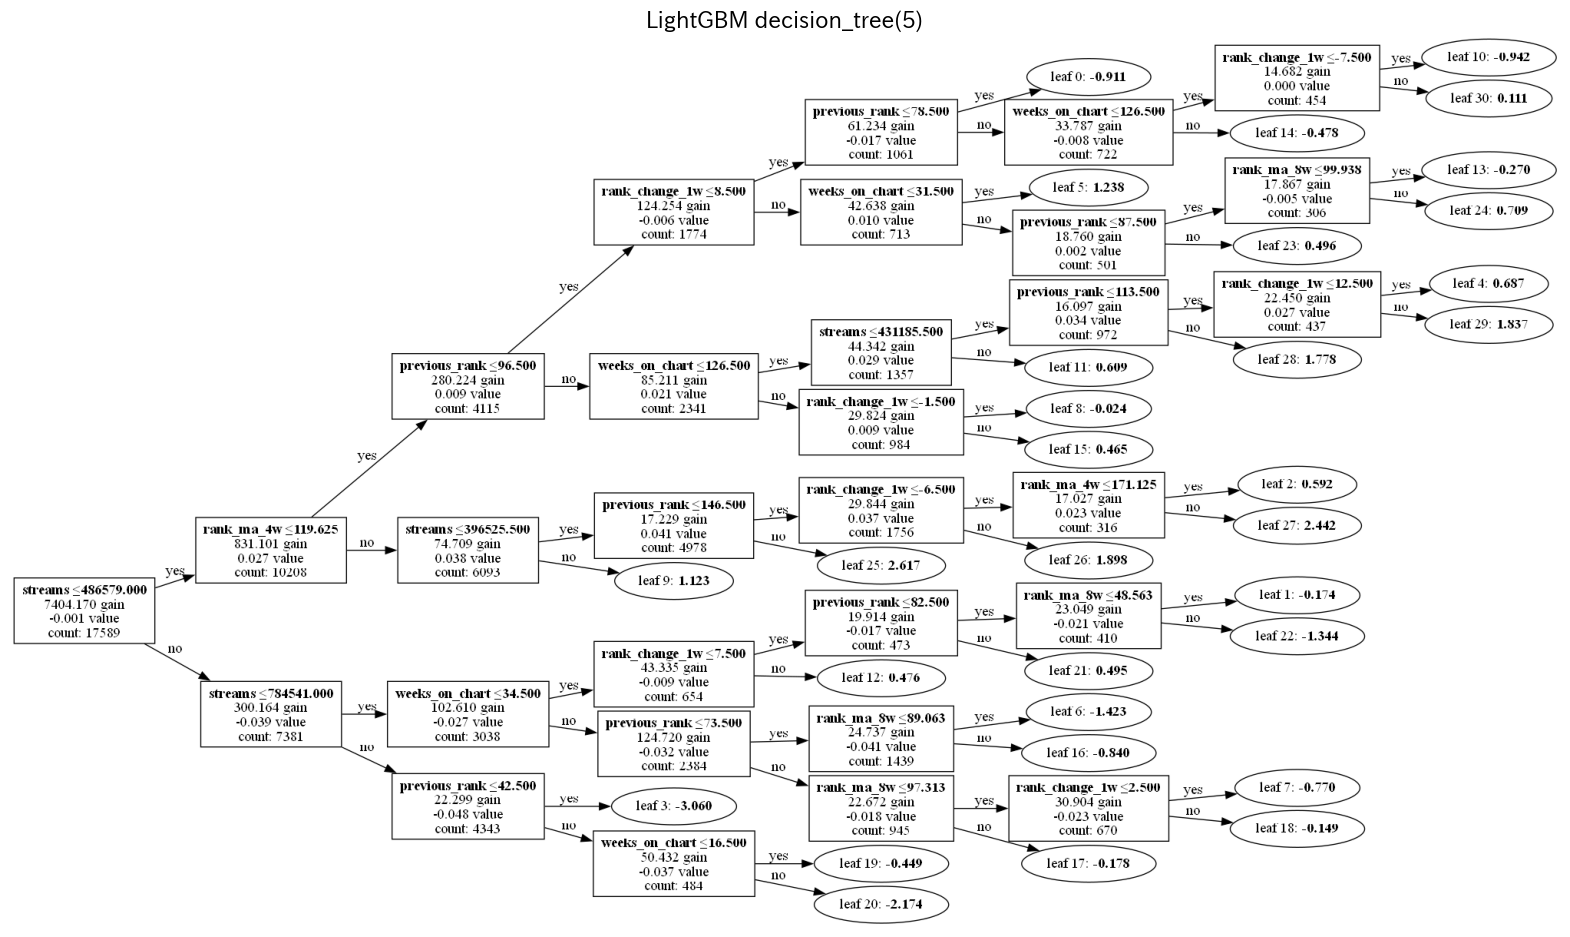

In [11]:
lgb.plot_tree(
    model, 
    tree_index=5,  
    figsize=(20, 16), 
    show_info=['split_gain', 'internal_value', 'internal_count'] 
)
plt.title('LightGBM decision_tree(5)', fontsize=16)
plt.savefig('decision_tree_5.png')
